<a href="https://colab.research.google.com/github/37stu37/FFE/blob/master/FFE_network_one_file_run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%time 
%%capture
!apt update
!apt upgrade
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 

CPU times: user 807 ms, sys: 119 ms, total: 926 ms
Wall time: 3min 26s


In [2]:
# Load the Drive helper and mount
from google.colab import drive
%tensorflow_version 2.x
# This will prompt for authorization.
drive.mount('/content/drive')
# pip freeze --local > /content/gdrive/My\ Drive/Colab Notebooks/pip_installed.txt

TensorFlow 2.x selected.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%%time
import datetime
import glob
import math
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
import networkx as nx
from shapely.geometry import Point
import imageio

pd.options.mode.chained_assignment = None  # default='warn'

CPU times: user 264 ms, sys: 66.4 ms, total: 330 ms
Wall time: 905 ms


Set up the path  to data and output

In [0]:
path = '/content/drive/My Drive/05_Sync/FFE/Mesa'
path_output = '/content/drive/My Drive/05_Sync/FFE/Mesa/output'

# !ls "/content/drive/My Drive/05_Sync/FFE/Mesa"

Create the functions to be used by the algorithm

In [0]:
def load_data(file_name, minx, miny, maxx, maxy):
    # crop data
    bbox = box(minx, miny, maxx, maxy)
    # building point dataset
    gdf_buildings = gpd.read_file(os.path.join(path, file_name), bbox=bbox)
    # gdf_buildings.IgnProb_bl = 0.02
    # xmin,ymin,xmax,ymax = gdf_buildings.total_bounds
    return gdf_buildings


def wind_scenario():
    wind_data = pd.read_csv(os.path.join(path, 'GD_wind.csv'))
    i = np.random.randint(0, wind_data.shape[0])
    w = wind_data.iloc[i, 2]
    d = wind_data.iloc[i, 1]
    b = wind_data.iloc[i, 3]
    return w, d, b


def create_network(edge_list_dataframe):
    graph = nx.from_pandas_edgelist(edge_list_dataframe, edge_attr=True)
    # options = {'node_color': 'red', 'node_size': 50, 'width': 1, 'alpha': 0.4,
    #            'with_labels': False, 'font_weight': 'bold'}
    # nx.draw_kamada_kawai(graph, **options)
    # plt.show()
    return graph

In [0]:
def set_initial_fire_to(df):
    """Fine = 0, Fire = 1, Burned = 2"""
    df['RNG'] = np.random.uniform(0, 1, size=len(df))  # add for random suppression per building, df.shape[0])
    onFire = df['source_IgnProb_bl'] > df['RNG']
    ignitions = df[onFire]
    # source nodes ignited
    sources_on_fire = list(ignitions.source)
    sources_on_fire = list(dict.fromkeys(sources_on_fire))
    return sources_on_fire


def set_fire_to(df, existing_fires):
    are_set_on_fire = (df['source'].isin(existing_fires))
    spark = df[are_set_on_fire]
    # source nodes ignited
    sources_on_fire = list(spark.source)
    sources_on_fire = list(dict.fromkeys(sources_on_fire))
    return sources_on_fire


def fire_spreading(list_fires, list_burn, wind_speed, wind_bearing, suppression_threshold, step_value, data):
    # check the fire potential targets
    # print("fire list before spreading : {}, length : {}".format(list_fires, len(list_fires)))
    are_potential_targets = (data['source'].isin(list_fires))
    are_not_already_burned = (~data['target'].isin(list_burn))
    df = data[are_potential_targets & are_not_already_burned]
    if df.empty:
        # print("no fires")
        list_burn.extend(list(list_fires))
        list_burn = list(dict.fromkeys(list_burn))
        return [], list_burn  # to break the step loop
    # set up additional CONDITIONS for fire spreading

    # neighbors selection from buffer
    are_neighbors = df['distance'] < wind_speed
    df = df[are_neighbors]

    # wind direction
    wind_bearing_max = wind_bearing + 45
    wind_bearing_min = wind_bearing - 45
    if wind_bearing == 360:
        wind_bearing_max = 45
    if wind_bearing <= 0:  # should not be necessary
        wind_bearing_min = 0
    if wind_bearing == 999:
        wind_bearing_max = 999
        wind_bearing_min = 0
    are_under_the_wind = (df['bearing'] < wind_bearing_max) & (df['bearing'] > wind_bearing_min)
    # print("targets under the wind ? {}".format(list(dict.fromkeys(list(are_under_the_wind)))))
    df = df[are_under_the_wind]
    # suppression
    df['random'] = np.random.uniform(0, 1, size=len(df))
    are_not_suppressed = df['random'] > suppression_threshold
    # print("fire suppressed ? {}".format(list(dict.fromkeys(list(are_not_suppressed)))))
    df = df[are_not_suppressed]

    # spread fire based on condition
    fire_df = df
    # fire_df = df[are_neighbors & are_under_the_wind & are_not_suppressed]  # issues with "are_under_the_wind
    # print(len(fire_df.head(5)))
    # print(len(fire_df))
    list_burn.extend(list(list_fires))
    fire_df['step'] = step_value
    fire_df.to_csv(os.path.join(path_output, "step{}_fire.csv".format(step_value)))
    list_fires = list(dict.fromkeys(list(fire_df.target)))
    list_burn.extend(list(fire_df.target))
    list_burn = list(dict.fromkeys(list_burn))
    return list_fires, list_burn


def log_files_concatenate(prefix, scenario_count):
    list_df = []
    files = glob.glob(os.path.join(path_output, prefix))
    if files:
        for file in files:
            # print(file)
            df = pd.read_csv(os.path.join(path_output, file))
            list_df.append(df)
            os.remove(file)
        data = pd.concat(list_df)
        data['scenario'] = scenario_count
        data.to_csv(os.path.join(path_output, "fire_scenario_{}.csv".format(scenario_count)))
    else:
        print("no files to concatenate")


def clean_up_file(prefix, path_path=path_output):
    files = glob.glob(os.path.join(path_path, prefix))
    for file in files:
        # print(file)
        os.remove(file)


def postprocessing(scenarios_recorded, burned_asset, edge_list, gdf_polygons):
    list_of_tuples = list(zip(scenarios_recorded, burned_asset))
    df = pd.DataFrame(list_of_tuples, columns=['scenarios', 'burned_asset_index'])
    # df['count'] = df['burned_asset_index'].value_counts().values
    df['count'] = df.groupby('burned_asset_index')['burned_asset_index'].transform('count')
    print(df.describe())
    df = df[['burned_asset_index', 'count']]
    df_count = pd.merge(df, gdf_polygon, left_on='burned_asset_index', right_on='TARGET_FID', how='left')
    fig, ax = plt.subplots(1, 1)
    df_count.plot(column='count', cmap='RdYlBu_r', ax=ax, legend=True)
    ax.title.set_text("Burned buildings after {} scenarios".format(max(scenarios_recorded)))
    plt.savefig(os.path.join(path_output, "results_{}.png".format(number_of_scenarios)))
    # plt.show()
    plt.close(fig)
    df_count = df_count.drop(columns=['source', 'source_TARGET_FID', 'source_X', 'source_Y', 'source_geometry'])
    # df_count.to_csv(os.path.join(path_output, "results_{}_scenarios.csv".format(scenario_recorded)))
    df_count.to_file(os.path.join(path_output, "results_{}_scenarios.shp".format(scenario_recorded)))
    return df_count, dataframe

In [45]:
list(E)

['source',
 'target',
 'azimuth',
 'bearing',
 'distance',
 'source_IgnProb_bl',
 'target_IgnProb_bl',
 'RNG']

In [0]:
def edge_list_itertuple(geodataframe, maximum_distance):
  list_dataframes = []
  for row in geodataframe.itertuples():
    source_list = [row.TARGET_FID] * len(geodataframe)
    source_list = np.hstack(source_list)
    target_list = list(geodataframe.TARGET_FID)
    frame = { 'source': source_list, 'target': target_list } 
    df = pd.DataFrame(frame)

    # create edgelist geodataframe to calculate distance and bearing
    polygons = geodataframe[['TARGET_FID', 'geometry', 'IgnProb_bl']]
    in_source_list = polygons['TARGET_FID'].isin(source_list)
    polygons_crop = polygons[in_source_list]

    # create a df from the source row selected of the length source list
    source_df = polygons_crop.append([polygons_crop]*(len(source_list)-1),ignore_index=True)
    source_df.rename(columns={'IgnProb_bl': 'source_IgnProb_bl'}, inplace=True)
    target_df = polygons.copy()
    target_df.rename(columns={'IgnProb_bl': 'target_IgnProb_bl'}, inplace=True)

    # convert to geodataframe and calculate centroid X Y 
    source_gdf = gpd.GeoDataFrame(source_df, geometry='geometry')
    target_gdf = gpd.GeoDataFrame(target_df, geometry='geometry')

    # calculate vectors between centroids
    v1 = source_gdf.centroid.x - target_gdf.centroid.x
    v2 = source_gdf.centroid.y - target_gdf.centroid.y
    
    # calcuate bearings between centroids
    df['azimuth'] = np.degrees(np.arctan2(v2, v1))
    df['bearing'] = (df['azimuth'] + 360) % 360

    # calculate distance
    distance_series = source_gdf.distance(target_gdf)
    df['distance'] = distance_series

    # add ignition probability
    df['source_IgnProb_bl'] = source_df['source_IgnProb_bl']
    df['target_IgnProb_bl'] = target_df['target_IgnProb_bl']

    # filter data based on distance
    not_himself = df['distance'] != 0
    above_the_threshold = df['distance'] < maximum_distance
    df = df[(not_himself) & (above_the_threshold)]

    # concatenate dataframes 
    list_dataframes.append(df)

  edge_list = pd.concat(list_dataframes)
  return edge_list

In [0]:
def main(number_of_scenarios, edges):
  clean_up_file("*csv")
  clean_up_file("*png")
  scenarios_list = []
  log_burned = []  # no removing duplicate
  # --- SCENARIOS
  t = datetime.datetime.now()
  for scenario in range(number_of_scenarios):
      t0 = datetime.datetime.now()
      burn_list = []
      print("--- SCENARIO : {}".format(scenario))
      fire_list = set_initial_fire_to(edges)
      x = fire_list
      if len(fire_list) == 0:
          print("no fire")
          continue
      w_direction, w_speed, w_bearing = wind_scenario()
      # --------- STEPS
      for step in range(len(edges)):
          print("--------- STEP : {}".format(step))
          fire_list = set_fire_to(edges, fire_list)
          y = fire_list
          fire_list, burn_list = fire_spreading(fire_list, burn_list, w_speed, w_bearing, 0, step, edges)
          if len(fire_list) == 0:
              break
      log_burned.extend(burn_list)
      scenarios_list.extend([scenario] * len(burn_list))

      log_files_concatenate('step*', scenario)
    
  return scenarios_list, log_burned

CPU times: user 217 ms, sys: 99.5 ms, total: 317 ms
Wall time: 252 ms


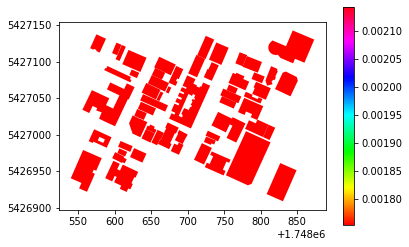

In [42]:
%%time
# load data
gdf_polygon = load_data("buildings_raw.shp", 1748570, 5426959, 1748841, 5427115)
gdf_polygon.plot(column='IgnProb_bl', cmap='hsv', legend=True)

CPU times: user 1.39 s, sys: 6.31 ms, total: 1.39 s
Wall time: 1.4 s


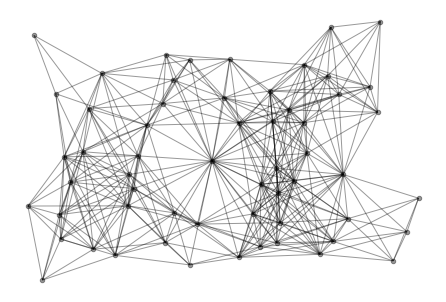

In [43]:
%%time
# create edge list and network
E = edge_list_itertuple(gdf_polygon, 45)

# create edges
G = create_network(E)

# plot network
options = {'node_color': 'black', 'node_size': 20, 'width': 1, 'alpha': 0.4,
               'with_labels': False, 'font_weight': 'bold'}
nx.draw_kamada_kawai(G, **options)

In [0]:
%%timeit
# run model
scos, burns = main(10, E)

In [0]:
# generate output
count_gdf, count_df = postprocessing(scos, burns, E, gdf_polygon)